In [1]:
import os
import torch
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from net import vgg16

## 数据预处理

In [2]:
"""
data_v是我把原数据resize成后重新保存的文件，用原64*64的也跑过，效果不好
"""
data_dir = '../data/data'

In [3]:
dataset = ImageFolder(data_dir+'/train', transform=transforms.Compose([transforms.Resize((224,224)),
                                                                        transforms.ToTensor()]))
classes = os.listdir(data_dir + "/train")

In [4]:
random_seed = 1234
torch.manual_seed(random_seed)

val_size = 8202 # 10% of the total size
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds)
val_data_size = len(val_ds)

In [5]:
batch_size= 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=0,pin_memory=True)

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        writer = SummaryWriter("logs")
        writer.add_image("dataloader", make_grid(images, nrow=16), 1)
        writer.close()
        break

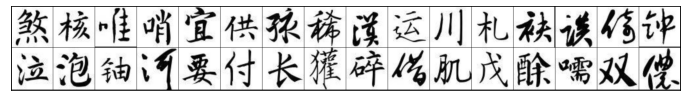

In [9]:
show_batch(train_dl)

## 构建网络

In [6]:
device=torch.device('cuda'if torch.cuda.is_available() else "cpu")
net=vgg16(pretrained=True, progress=True,num_classes=20)
net.to(device)
writer = SummaryWriter("logs")
writer.add_graph(net, input_to_model=torch.rand(1,3,224,224).to(device))

## 选择优化器和学习率



In [7]:
lr=0.0001
optim=torch.optim.Adam(net.parameters(),lr=lr)
sculer=torch.optim.lr_scheduler.StepLR(optim,step_size=1)


## 训练



In [8]:
total_train_step = 1
total_val_step = 1
epochs=3 # 循环次数
for epoch in range(epochs):
    total_train=0
    for data in train_dl:
        img,label=data
        img =img.to(device)
        label=label.to(device)
        optim.zero_grad()
        output=net(img)
        train_loss=nn.CrossEntropyLoss()(output,label).to(device)
        train_loss.backward()
        optim.step()
        total_train+=train_loss
        total_train_step += 1
        if total_train_step % 100 == 0:
            writer.add_scalar("train_loss", total_train, total_train_step)
    sculer.step()
    total_test=0
    total_accuracy=0
    for data in val_dl:
        img,label =data
        with torch.no_grad():
            img=img.to(device)
            label=label.to(device)
            out=net(img)
            test_loss=nn.CrossEntropyLoss()(out,label).to(device)
            total_test+=test_loss
            accuracy=(out.argmax(1)==label).sum()
            total_accuracy+=accuracy
    print("训练集上的损失：{}".format(total_train))
    print("验证集上的损失：{}".format(total_test))
    print("验证集上的精度：{:.1%}".format(total_accuracy/val_data_size))
    writer.add_scalar("val_loss", total_test, total_val_step)
    writer.add_scalar("val_accuracy", total_accuracy/val_data_size, total_val_step)
    writer.add_scalar("learnig_rate", optim.param_groups[0]["lr"], total_val_step)
    total_train_step += 1
    total_val_step += 1
    # torch.save(net,"dogandcat.{}.pt".format(epoch+1))
    torch.save(net.state_dict(),"Adogandcat.{}.pth".format(epoch+1))
    print("模型已保存")


训练集上的损失：1091.4278564453125
验证集上的损失：51.432926177978516
验证集上的精度：97.1%
模型已保存
训练集上的损失：102.4695816040039
验证集上的损失：16.433616638183594
验证集上的精度：98.9%
模型已保存
训练集上的损失：29.352842330932617
验证集上的损失：11.256389617919922
验证集上的精度：99.3%
模型已保存
